<a href="https://colab.research.google.com/github/thad75/TP_ENSEA_ELEVE/blob/main/3A/SIA/TP4/Attention_in_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning
!pip install wandb

USE_COLAB = True
CONTENT_DIR = "/content" if USE_COLAB else "."

import wandb
if not wandb.login():
    raise ValueError("WandDB authentification failed.")
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
import os
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)
import numpy as np
from PIL import Image
from torch.utils.data import random_split
from torchvision.datasets import MNIST
import cv2 as cv
from google.colab.patches import cv2_imshow
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from typing import Optional, List
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.loggers import WandbLogger
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

# Transformer : A Model Used Everywhere



---


Goal of this lab :     


*   Understand and code basic Transformer 
*   Introduction to Finance
*  Understand your knowledge of deep learning.
* Become Rich ?

**Disclaimer : ANY NON ILLUSTRATED ANALYSIS WILL LEAD TO A 0 TO THE GIVEN PART**

<img src ="https://i.imgflip.com/6g1fwb.jpg?a463272" height = 200>




---




We have seen through multiple labs industrial applications of Deep Learning models in Computer Vision. Now let's look at another task.

# Transformer : Definitions


## Model


The transformer is a  network architecture based on attention mechanisms. It consists of an encoder-decoder architecture: 
* the encoder maps an input sequence of symbol representations $(x_1,…,x_n)$ to a sequence $z=(z_1,…,z_n)$ 
* the decoder, given $z$ , generates an output sequence $(y_1,…,y_m)$. 

At each time step, the model consumes the previously generated symbols as additional input when generating the next (it is auto-regressive) 

<img src="https://miro.medium.com/max/1400/1*BHzGVskWGS_3jEcYYi6miQ.png" width= 400>

## Positional Encoding

Transformers work on a sequence of Data. Order does matter. 
Example :  


> **Vivre pour manger =! Manger pour vivre.**




For recurrent networks (RNN, LSTM, GRU), the word positions are implicitly embedded inside the model since they are processed sequentially. The Transformer doesn't process sequentially the input. How can we specify the position of a Token ?
The solution of the authors was to add a vector representing the position of the words to the embedding vectors: 


> **THE POSITIONAL ENCODING**




## Attention : The reason of this model

Attention , self-attention and multi-head attention are the main component of this model. They let the model know that specific regions or tokens are interesting. They let the model take care of specific parts of the input

# Finance : Is attention all you need ?

In this lab, we will try to create a model able to predict trends in Stock Values. This might be a foundation for a trading bot. We will use a Transformer Encoder to perform this task.

Feel free to download any stock you want.
Some examples of stock : 
* S&P500 : https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC , https://www.investing.com/indices/us-spx-500-historical-data, https://www.nasdaq.com/market-activity/index/spx/historical
* Bitcoin : https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD
* Gold : https://finance.yahoo.com/quote/GC%3DF/history?p=GC%3DF
* ...

To download your csv file, go on the Historical Data tab, choose a Time Period and Download your file.

**Important : Make sure that you have a historical data of a long period of time.**



### I - Time Series : A Different Dataset

Time Series are a series of data points indexed by time. We often treat them by sequence of equally spaced points in time.

#### a - EDA : What Trends in your stock ?

Let's read your stock file. As a Data Scientist, you will be asked to explore data before doing anything. Data Exploration is needed for data understanding and preprocessing.
* Using Pandas perform a full Exploratory Dataset Analysis.

Feel free to read the documentation of each library. It will be needed to perform anything

Is expected : 
* A description of the stock
* A summary of the features 
* What could be the trend for next week ?
* Plots of the useful features.
* Correlation between features.

Some useful libraries :    
* To read a csv file : use **pandas** library and read_csv method
* **seaborn** is a useful library that processes a pandas dataframe 
* **matplotlib** is your old friend

Some useful methods :    
* In pandas : 
  * head() 
  * describe()
* In seaborn:
 * displot()



In [ ]:
import pandas as pd

df= pd.read_csv(...)

#### b - Creating a Stock Dataset

As you might have seen, multiple features are available in the dataset. We will use the attention mecanism to process 5 of the given features. We will use the following features :    
* Open
* High
* Low
* Close
* Volume

We are going to create a Dataset that is conform to Pytorch Dataset class.
The Dataset should take as input :
*    Dataframe(s?)
*    $N_{window}$ : length of the sequence 


We're feeding the model Time Series which are sequential datas. Each data $p_{i}$ is part of a sequence of length $N_{window}$. We want to predict what could happen after that data. We are sending the data thanks to a sliding non overlapping window of size $N_{window}$. 

In fact, we will be sending $N_{window}$ sequences to the model to learn how to approximate  $f( W_t) \approx W_{t+1}$ \
where :


$W_t = (p_{t_{w}}, p_{t_{w+1}}, \dots, p_{(t+1)_{w-1}})$

We want the dataset to return the following:
for 

*    $N_{window}$ = 3


$\text{Input}_1 = [p_0, p_1, p_2], \text{Label}_1 = [p_3, p_4, p_5]$ \


$\text{Input}_3 = [p_6, p_7, p_8], \text{Label}_3 = [p_9, p_{10}, p_{11}]$

__getitem__ method should return a dictionnary where : 
*   dict['input'] : is a list of $N_{window}$ input values
* dict['label'] : is a list of $N_{window}$ target values


In [ ]:
class StockDataset(Dataset):

  def __init__(self, df,N_window,normalized = True,num_steps =1):
      self.df = df
      self.df.dropna(how='any', axis=0,inplace= True)
      self.N_window = N_window
      self.num_steps =num_steps
      self.normalized = normalized
      self.X, self.y = self.process_df()

  def process_df(self):
      """
      process method should return X,y: 
      * X is an array of num_steps*N_windows input values
      * y is an array of corresponding target values
      """
      scaler = MinMaxScaler(feature_range=(-1, 1))
      data_raw= self.df.to_numpy()
      close = self.df['Close'].to_numpy()
      open = self.df['Open'].to_numpy()
      high = self.df['High'].to_numpy()
      low = 	self.df['Low'].to_numpy()
      volume = self.df['Volume'].to_numpy()

      if self.normalized : 
        close = scaler.fit_transform(close.reshape(-1, 1))
        open = scaler.fit_transform(open.reshape(-1, 1))
        high = scaler.fit_transform(high.reshape(-1, 1))
        low = 	scaler.fit_transform(low.reshape(-1, 1))
        volume = scaler.fit_transform(volume.reshape(-1, 1))

      data_raw= np.stack([close,open,high,low,volume])
      assert len(close)==len(open)==len(high)==len(low)==len(volume)

      # TODO : Create a list of sequences of N_window elements
      seq = ...
      # TODO : Return an array of sequences where X is the input values and y the target values               
      X = ...
      y = ...
      return X,y

  def __len__(self):
      '''
      Be careful on your len because of the overlapping issues
      '''
      # TODO : What is the len of the dataset ?
      return ...

  def __getitem__(self,idx):
      """
      __getitem__ method should return a dictionnary where : 
      * dict['input'] : is a list of num_{steps} lists of N_{window} elements
      * dict['label'] : is a list of N_{window} target value
      """
      # TODO : Return one element
      x = ...
      y = ...
      return {'input': x.squeeze(-1), 
              'label':y.squeeze(-1)}

In [ ]:
# TODO : Verify that your Dataset is correct.

df = ...
N_window = ...
normalized = ...
dataset = StockDataset(df = ...,
                       N_window = ...,
                       normalized = ...)


At this moment, each samples will be a dictionnary with a sequence. However, one important feature is hidden in our stock price but we need a proper way to use it. 
* What feature are we talking about ?


#### c- Creating the Lightning DataModule

As usual create a Lightning Datamodule that encompasses everything. 

In [ ]:
class StockDataModule(pl.LightningDataModule):
    def __init__(self,df,N_window, normalized, batch_size):
        super().__init__()
        self.df = df
        self.N_window = N_window
        self.normalized = normalized
        self.batch_size = batch_size
        
    def setup(self, stage):
        # First stage is 'fit' (or None)       

        # TODO : Do we shuffle the datasets ? Why ?
        X_train, X_test = train_test_split(self.df, shuffle=...)
        X_train, X_valid = train_test_split(X_train, shuffle=...)

        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            # TODO : As usual
            self.stock_train =  StockDataset(...)
            self.stock_valid =  StockDataset(...)

        # Second stage is 'test' 
        if stage == "test" or stage is None:
            # TODO : As usual
            self.stock_test =  StockDataset(...)

    def train_dataloader(self):
        return DataLoader(self.stock_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.stock_valid, self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.stock_test,self.batch_size, shuffle=True)

In [ ]:
# TODO : Initialize your datamodule



### II - Positional Encoding : Incorporating Time to the features with Time2Vector

Transformers use a posiional encoding to provide a sense of word order in a sequence. However, these positional encodings doesn't provide any sens of time. In that way, Time2Vector is a model-agnostic vector representation for time. The main idea of this vector is that : 
* a meaningful representation of time has to include both periodic and non-periodic patterns.
* a time representation should have an invariance to time rescaling



Specifically, a Time2Vec Layer is defined as :    
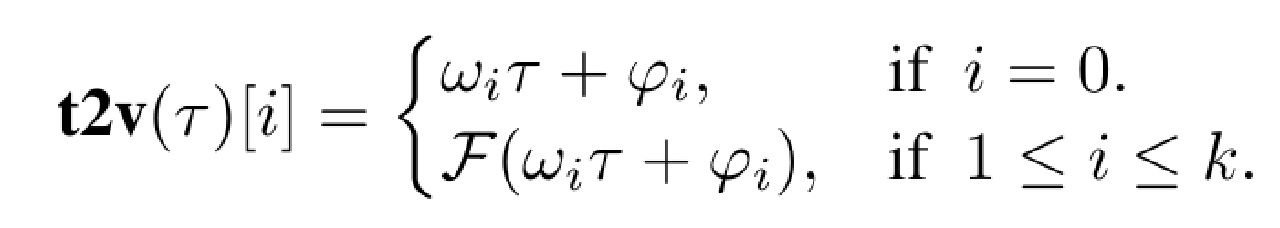

* $\mathcal{F}$ is a periodic function for e.g. sin or cos
* $w_i$, $\varphi_{i}$   are learnable parameters




Let's create a Time2Vec Layer. We need non-periodic feature and a periodic feature.
* To your opinion is there a useless feature to exclude of this time embedding ?
* Why ?



**Important Disclaimer : Usually we add our positional encoding to our input tensor. However, in our case we will concatenate it.**

In [ ]:
import torch
from torch import nn
import numpy as np
import math

class Time2Vector(nn.Module):

  def __init__(self,in_features):
      super().__init__()
      self.in_features = in_features 
      self.w0 = nn.parameter.Parameter(torch.randn(1,1), requires_grad =True)
      self.b0 = nn.parameter.Parameter(torch.randn(in_features, 1), requires_grad =True)
      self.w = nn.parameter.Parameter(torch.randn(1,1), requires_grad =True)
      self.b = nn.parameter.Parameter(torch.randn(in_features, 1), requires_grad =True)
      self.f = torch.sin


  def forward(self,x):
      bs,seq_len,n_feat = x.shape
      # TODO : Exclude the unwanted feature and compute the mean along the last axis
      x = ...

      linear = x.unsqueeze(-1) 
      periodic = x.unsqueeze(-1)
      linear = torch.matmul(linear,self.w0) + self.b0 
      W = self.w.repeat(bs,1,1)
      b = self.b.repeat(bs,1,1)
      periodic = self.f(torch.bmm(periodic,W) + b) 
      return torch.cat([linear, periodic], -1).permute(0,2,1)

# TODO : Verify the output of Time2Vector shape. It should be of shape (Batch Size, Sequence Length, 2)


### III - Transformer : A Big Model around Attention

We are going to build each modules of our Transformer model. The heart of the model resides in the Attention Mecanism. The goal of the Attention mecanism is to force the model to look at specific part of the input. We will build each component of the transformer part by part.


Create the different components of the Transformer Encoder : 
* Attention Module
* Multi-Head Attention Module
* Transformer Encoder Layer
* Transformer Encoder

#### a - Attention layer

Let's compute the attention layer. We will create a layer that computes Bandhanau's attention also called Dot Scale Product attention. The attention mecanism takes an input $X$ and project it using a set of queries, keys and values. Think of it as a Database which you query (with the queries) using a set of keys, which returns a set values.

Mathematicaly speaking, we are computing the scaled dot product between $Q$, $K$, $V$


The  attention is : 
$Attention(Q,K,V)$ =  $Softmax(\frac{Q*K}{\sqrt{dim}})$$*V$

<img src="https://production-media.paperswithcode.com/methods/SCALDE.png" height = 400>

In [ ]:
class Attention(nn.Module):

  def __init__(self, dim_query):
    super().__init__()
    self.dim_query = dim_query 

  
  def forward(self,q,k,v):
    # TODO : Compute the attention mecanism between q,k,v
    attn = torch.bmm(...,...)/math.sqrt(self.dim_query)
    attn = F.softmax(attn,-1)
    context = torch.bmm(...,...)
    return context, attn


#### b - Multi head Attention 

Usually, we like creating a Multi-Head Attention layer. Multi-Head only means that we are computing the attention over multiple heads. In fact, instead of having only one function computed by the attention mecanism, we leave each head free to learn a different function. Hence, we will have different outputs each computing a different value.

Mathematically speaking : 

$MultiHead(Q,K,V)=Concat(head_1,…,head_h)W^O$

with $head_i=Attention(QW_i^Q,KW_i^K,VW_i^V).$


<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTv6Bgq7bdnXdT-JDWEnnzK2EM1xY0NUEOyBg&usqp=CAU'>

 Question :    
 * What is $W^O$ ? Is it a learned parameter ?

In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self, embed_dim, dim_query, dim_value,num_heads):
        super().__init__()

        # Embed dim is the shape of the feature space
        self.embed_dim = embed_dim
        # Num Heads is the number of heads
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.w_query = nn.Linear(embed_dim, num_heads*dim_query)
        self.w_key = nn.Linear(embed_dim, num_heads*dim_query)
        self.w_value = nn.Linear(embed_dim, num_heads*dim_value)
        self.linear = nn.Linear(num_heads*dim_value, embed_dim)
        # Dim Query, Dim Value are the projected dimensions of each tensors
        self.attention = Attention(dim_query)


  def forward(self, query, key, value):

      # TODO : Project your query, key, value into their respective heads
      q = self.w_query(...)
      k = self.w_key(...)
      v = self.w_value(...)
      # TODO : Compute the attention 
      attn, context  = self.attention(...,...,...) 
      attn = self.linear(attn)
      return attn, context

#### c - Transforming the Transformer

So let's create our Transformer model. We will just create the Encoder, as we don't need the Decoder in our case. We are just trying to Encode the input and find interesting patterns.
Usually we code the Transformer Model into a specific format :
* Layer Class
* Model Class

<img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" height=400>

In [ ]:
# TODO : Create one Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):

  def __init__(self,embed_dim, dim_query, dim_value, num_heads, dim_feedforward= 256,dropout = 0.1):
      super().__init__()
      self.attention = MultiHeadAttention(embed_dim, 
                                          dim_query,
                                          dim_value, 
                                          num_heads)

      self.linear= nn.Sequential(nn.Linear(embed_dim, dim_feedforward),
                                  nn.ReLU(),
                                  nn.Dropout(dropout), 
                                  nn.ReLU(),
                                  nn.Linear(dim_feedforward, embed_dim))

      self.norm1 = nn.LayerNorm(embed_dim)
      self.norm2 = nn.LayerNorm(embed_dim)
      self.dropout1 = nn.Dropout(dropout)
      self.dropout2 = nn.Dropout(dropout)



  def forward(self, sequence):
      q=k=v= sequence.double()
      # TODO : Compute the attention 
      attn, context = ... 
      sequence = sequence + self.dropout1(attn)  
      sequence = self.norm1(sequence)
      sequence = self.linear(sequence)
      sequence = sequence +  self.dropout2(sequence)
      sequence = self.norm2(sequence)
      return sequence

# TODO : Create a Transformer Encoder. 
class TransformerEncoder(nn.Module):
  def __init__(self, encoder_layer, num_layers):
          super().__init__()
          self.layers = _get_clones(encoder_layer, num_layers)
          self.num_layers = num_layers

  def forward(self, sequence):
        output = sequence.permute(2,0,1)
        for layer in self.layers:
            # TODO : Send your Input to your transformer
            output = layer(...)
        return output


#### Building the entire model 

Finally let's build the entire model. Let's use Pytorch-Lightning to encompass everything. 
Normally your model must be composed of three components : 
* The Transformer
* The Time2Vector 
* A Regression Head 

As usual ask yourself what task you are performing, how your data should travle trhough the model, what the data is, blablablablalablba

Don't forget to use your favorite logger.

In [ ]:
class StockModel(pl.LightningModule):
    def __init__(self,embed_dim,dim_query,dim_value, num_layers, num_heads):
        super().__init__()
        self.save_hyperparameters()
        # TODO : Define your model here, be careful, your model will be an instance of the class. Watch  out for the input data.
        # TOOD : Define your Encoder Layer
        encoder_layer = TransformerEncoderLayer(embed_dim = ..., # TODO : What should be the hidden dim ?
                                                dim_query = dim_query, 
                                                dim_value = dim_value,
                                                num_heads = num_heads, 
                                                dim_feedforward= 256,
                                                dropout = 0.1)
        
        # TODO : Initialize your Transformer
        self.transformer = TransformerEncoder(encoder_layer = ...,
                                              num_layers = ...)
        # TODO : Initialize your regression head
        self.head = nn.Linear(...,...) # What is your input hidden dim, output hidden dim ? Don't forget your time embedding
        # TODO : Initialize your Time2Vector Embeddings
        self.timeencoder = Time2Vector(...) # What is the in_features dimension ? Is it the same as the input ?



    def forward(self,x):
        bs,h,len = x.shape
        pos = x.permute(0,2,1)
        time_vec = self.timeencoder(pos)
        # TODO : Concatenate your time embedding to the input sequence
        x = torch.cat(...) # TODO : Verify that the tensor was correctly concatenated within the feature dim
        # TODO : Send your input through your transformer
        x = self.transformer(x)
        x = x.view(bs*len, -1)
        # TODO : Send your input through the regression head
        x = self.head(x)
        x = x.view(bs,-1,len)
        return x

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer


    def training_step(self, batch, batch_idx):
        # TODO : Define your Training Step
        X,y = ...
        out = ...
        loss = ...
        # Don't remove the next line, you will understand why later
        self.log('train_loss', loss)
        return loss


    def validation_step(self, batch, batch_idx):
        # TODO : Define your Validation Step
        X,y = ...
        out = ...
        loss = ...
        # Don't remove the next line, you will understand why later
        self.log('val_loss', loss)
    
    def test_step(self, batch, batch_idx):
        # TODO : Define your Test Step
        X,y = ...
        out = ...
        loss = ...
        self.log('test_loss', loss)


## IV - Training the Model

* Initialize a model with 3 stacks of Encoder with 8 heads.
* What is the Embed Dimension ?
* What is the Dimension of a Query, Key and Value ? 



In [ ]:
# TODO : Initalize Model, Datamodule and Trainer
embed_dim = ...
num_heads = ...
dim_query = ...
dim_value = ...
num_layers = ...

model = StockModel(embed_dim=...,
                      dim_query=...,
                      dim_value=..., 
                      num_layers=..., 
                      num_heads= ...).double()


dm = ...

trainer = ...


In [ ]:
# TODO : Fit the Data to the Model

## V - Testing the model : Inference 

Now that the model is trained, testing it is a key to become rich.

#### a - Testings 

Test the model on the test dataset.

* What happens ?
* What can we do to enhance the results ?
* Will you deploy the model ?
* What are your predictions for next week ? Can we invest or not ?

**Illustrate your arguments using charts or any kind of visual materials supporting your analysis. Any non illustrated analysis won't be taken into account**

#### b - Further Testings 

Test the model on a different dataset.
* What can you say ?
* What are your predictions for next week ? Can we invest or not ?

**Illustrate your arguments using charts or any kind of visual materials supporting your analysis. Any non illustrated analysis won't be taken into account**
